# CyNetDiff Demo

This notebook is meant as a demonstration of the capabilities of the CyNetDiff library for simulating network diffusion. We will go through some typical use cases that highlight how CyNetDiff enables execution of network diffusion simulations on larger graphs.

## Background

We briefly review background on network diffusion. For our purposes, network diffusion is a stochastic process modeling the spread of trends through a graph . Nodes are either "active" (adopting the trend) or "inactive", and we are usually interested in the total number of active nodes by the end of this process. At the start, only nodes in the seed set are active, and later nodes are activated by rules dictated by the model. The process stops once no more nodes can be activated.

As these models are stochastic, computing the number of activated nodes is done by Monte-Carlo sampling, which can be very expensive once the number of samples or size of the graph become large.

Two of the most common models are Independent Cascade and Linear Threshold, and we will focus on Independent Cascade for this demo. Note however that `CyNetDiff` can simulate both of these models with a similar interface.


In [1]:
# Imports

from IPython.display import display
import networkx as nx
import random
from cynetdiff.utils import (
    networkx_to_ic_model,
    set_activation_random_sample,
    set_activation_weighted_cascade,
    set_activation_uniformly_random,
)
from coloraide import Color
import demo_backend as db
import typing as t

Graph = nx.Graph | nx.DiGraph

RANDOM_SEED = hash("CyNetDiff is very fast!")

# Simulating Diffusion

As a motivating example, suppose we would like to simulate an independent cascade a graph with a randomly chosen seed set. If we define the graph with standard NetworkX functions, then we can easily run multiple simulations with CyNetDiff.

## Independent Cascade Model

In the independent cascade model, given a (possibly directed) graph $G=(V,E)$, the process starts with a set $S \subseteq V$, called the seed set, being the initially active nodes. When a node $v \in V$ first becomes active, it will be given a single chance to activate each currently inactive neighbor $w$. The activation succeeds with probability $p_{v,w}$ (independent of the history thus far). If $w$ has multiple newly activated neighbors, their attempts occur in an arbitrary order. If $v$ succeeds, then $w$ will become active; but whether or not $v$ succeeds, it cannot make any further attempts to activate $w$ in subsequent rounds. The process runs until no further activation is possible.

Further, let $\sigma(S)$ denote the _influence_ of $S$, which is the expected number of nodes activated with $S$ as a seed set.


In [2]:
n = 1_000  # Number of nodes in the graph
p = 0.01  # Probability of an edge
graph = nx.gnp_random_graph(n, p, RANDOM_SEED)
# Set activation probability to 0.1 on every edge
set_activation_random_sample(graph, {0.1})

k = 10  # Number of seed nodes
seeds = random.sample(list(graph.nodes()), k)

# Number of trials to average
num_trials = 1_000

total_activated = 0.0

# Initialize the independent cascade model
ic_model = networkx_to_ic_model(graph)
ic_model.set_seeds(seeds)

for _ in range(num_trials):
    ic_model.advance_until_completion()
    total_activated += ic_model.get_num_activated_nodes()
    ic_model.reset_model()

# Get the average number activated.
avg_activated = total_activated / num_trials
print(f"Average number of activated nodes: {avg_activated}")

Average number of activated nodes: 103.047


# Simple Benchmarks (start the next cell before reading)

For large graphs run over many trials, this simulation task can be computationally expensive. To observe how CyNetDiff tackles this compared to other Python packages, we have functions that do diffusion averaging as above and display a progress bar. The `ndlib` backend runs the diffusion process with the [NDlib](https://ndlib.readthedocs.io/en/latest/) library, the `python` backend is an optimized pure python implementation, and the `cynetdiff` backend uses our library.

`db.simple_benchmark` simulates diffusions on a graph with all three libraries, including progress bars and timing information.


In [3]:
db.simple_benchmark(graph)

Number of randomly chosen seed nodes: 10
Graph nodes: 1_000
Graph edges: 4_891
Number of trials: 1_000
Starting diffusion with NDlib.


  0%|          | 0/1000 [00:00<?, ?it/s]

func:'diffuse_ndlib' took: 8.5435 sec
Starting diffusion with pure Python.


  0%|          | 0/1000 [00:00<?, ?it/s]

func:'diffuse_python' took: 0.4525 sec
Starting diffusion with CyNetDiff.


  0%|          | 0/1000 [00:00<?, ?it/s]

func:'diffuse_CyNetDiff' took: 0.0414 sec
NDlib avg activated: 102.318
Pure Python avg activated: 106.004
CyNetDiff avg activated: 104.863


# Benchmarks on Artificial Data

CyNetDiff is very fast, performing much better than even optimized pure Python. This is a result of using a complied extension module, with data structures that minimize memory usage (graphs are stored in [CSR format](https://www.usenix.org/system/files/login/articles/login_winter20_16_kelly.pdf)). Observe that we have similar performance on different graphs and weighting schemes.


In [4]:
# Small world graph.
small_world_graph = nx.watts_strogatz_graph(1_000, 10, 0.01, seed=RANDOM_SEED)
set_activation_random_sample(small_world_graph, {0.1, 0.01, 0.001})

# Paley graph with weighted cascade.
paley_graph = nx.paley_graph(500).to_directed()
set_activation_weighted_cascade(paley_graph)

# Lobster graph with weights chosen uniformly at random.
lobster = nx.random_lobster(2500, 0.3, 0.3, seed=RANDOM_SEED)
set_activation_uniformly_random(lobster, range_start=0.2, range_end=0.8)

# NOTE Change the benchmark graph to see different runs
db.simple_benchmark(lobster, backends_to_run=["ndlib", "cynetdiff"])

Number of randomly chosen seed nodes: 10
Graph nodes: 6_455
Graph edges: 6_454
Number of trials: 1_000
Starting diffusion with NDlib.


  0%|          | 0/1000 [00:00<?, ?it/s]

func:'diffuse_ndlib' took: 23.0413 sec
Starting diffusion with CyNetDiff.


  0%|          | 0/1000 [00:00<?, ?it/s]

func:'diffuse_CyNetDiff' took: 0.0212 sec
NDlib avg activated: 37.68
CyNetDiff avg activated: 37.718


# Benchmarks on Real-World Data

We also include the ability to download data from the [SNAP](http://snap.stanford.edu/data/index.html) graph datasets. See the following cell for an example.


In [6]:
downloader = db.GraphDownloader()

# Print all graphs available to download
display(downloader.list_graphs())

# Choose the Epinions graph and set weighted cascade.
print("Preparing to benchmark on Epinions graph.")
big_graph = downloader.get_graph("soc-Epinions1.txt.gz").to_directed()
set_activation_weighted_cascade(big_graph)

# Run a simple benchmark on this graph.
db.simple_benchmark(big_graph, backends_to_run=["cynetdiff"])

['facebook_combined.txt.gz',
 'twitter_combined.txt.gz',
 'wiki-Vote.txt.gz',
 'soc-Epinions1.txt.gz']

Preparing to benchmark on Epinions graph.
Number of randomly chosen seed nodes: 10
Graph nodes: 75_879
Graph edges: 811_480
Number of trials: 1_000
Starting diffusion with CyNetDiff.


  0%|          | 0/1000 [00:00<?, ?it/s]

func:'diffuse_CyNetDiff' took: 0.7672 sec
CyNetDiff avg activated: 92.936


# Visualizations

One way to leverage the high performance of CyNetDiff is by scaling up the complexity of visualizations. The visualization code in this section extracts information from CyNetDiff and renders this using external libraries.

## Heatmap

As a motivating example, suppose we want to visualize which nodes are activated most often across trials during the network diffusion process. This is possible by recording which nodes get activated after each trial, and maintaining counts across trials.

Below, we provide code that creates this visualization. Nodes that are visited more often are displayed in red and less visited nodes are in blue. Observe that seed nodes (which are always visited) are red.


Seeds:  [10, 6, 18, 37]


  0%|          | 0/1000 [00:00<?, ?it/s]

func:'diffusion_get_frequencies' took: 0.0630 sec


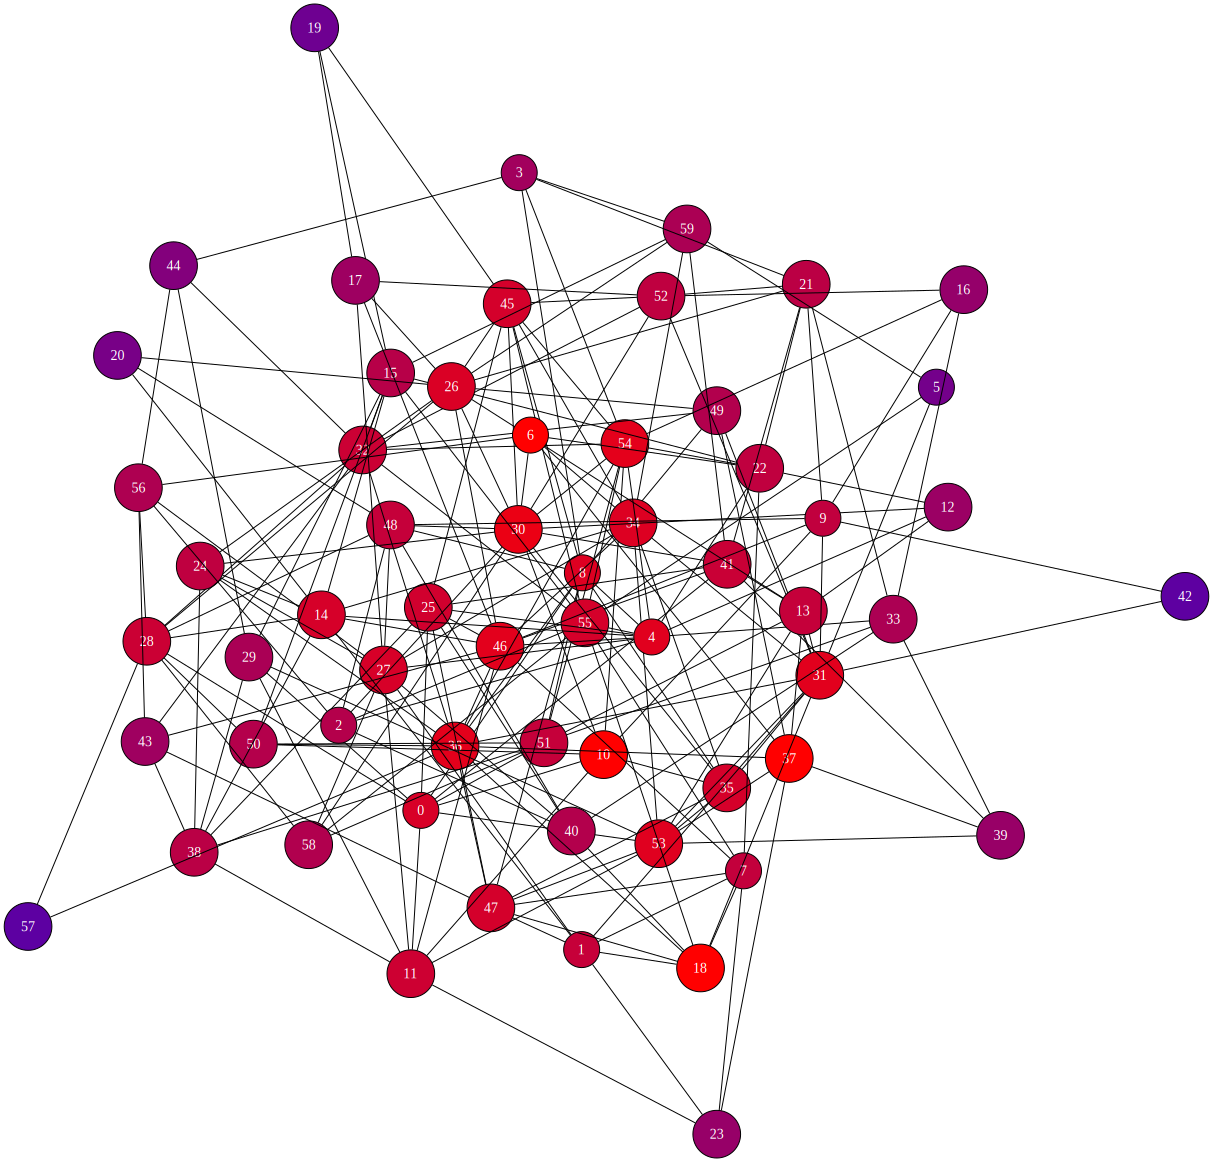

In [ ]:
# Generate the graph and set activation probabilities uniformly to 0.2.
small_graph = nx.gnp_random_graph(60, 0.1)
seeds = random.sample(list(small_graph.nodes()), 4)
set_activation_random_sample(small_graph, {0.25})

# Print number of seeds and display the graph.
print("Seeds: ", seeds)
cascade_frequencies = db.diffusion_get_frequencies(small_graph, seeds)
db.draw_graph(small_graph, cascade_frequencies)

# Diffusion Over Time

As another example, suppose we want to plot the growth in the number of activated nodes over time under different diffusion scenarios. To do this, we leverage [`Matplotlib`](https://matplotlib.org/) along with data gathered from CyNetDiff. In this example, we will be comparing the quality of diffusion by choosing different seed sets over the same randomly generated graph.

For this example, we will compare the number of activated nodes between a randomly chosen seed set, and using the highest degree nodes as seeds. Observe that the high-degree nodes activate a substantially higher number of nodes than the randomly chosen subset.


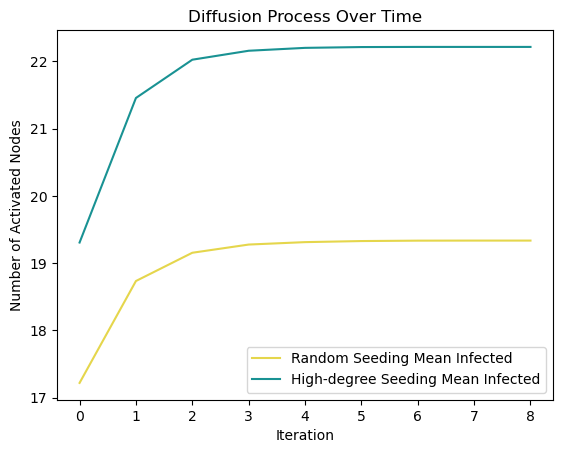

In [8]:
diff_graph = nx.watts_strogatz_graph(1_000, 5, 0.1, seed=RANDOM_SEED)

num_seeds = 12
random_seeds = set(random.sample(list(diff_graph.nodes()), num_seeds))
high_deg_seeds = sorted(diff_graph.nodes(), key=diff_graph.degree, reverse=True)[
    :num_seeds
]

db.plot_num_nodes_activated(
    [
        ("Random Seeding", diff_graph, random_seeds),
        ("High-degree Seeding", diff_graph, high_deg_seeds),
    ]
)

# Comparing Weighting Schemes

For a second example using a similar setup, let's plot the mean number of infected nodes of different weighting schemes. With respect to the independent cascade model, the weighting scheme is how the probabilities $p_{v,w}$ are chosen. There are three common weighting schemes handled by utility functions from `CyNetDiff`:

- We can choose the weights $p_{v,w} \in [0,1]$, uniformly at random. This can be set by calling the function `set_activation_uniformly_random(graph)` on a given graph.
- We can choose the weights $p_{v,w}$, uniformly at random from a set `weight_set`. This can be set by calling the function `set_activation_random_sample(graph, weight_set)` on a given graph.
- We can choose the weights $p_{v,w} = \frac{1}{|N^-(w)|}$ as the inverse of the in-degree of $w$. This can be set by calling the function `set_activation_weighted_cascade(graph)` on a given graph. The input graph must be _directed_ to use this weighting scheme.


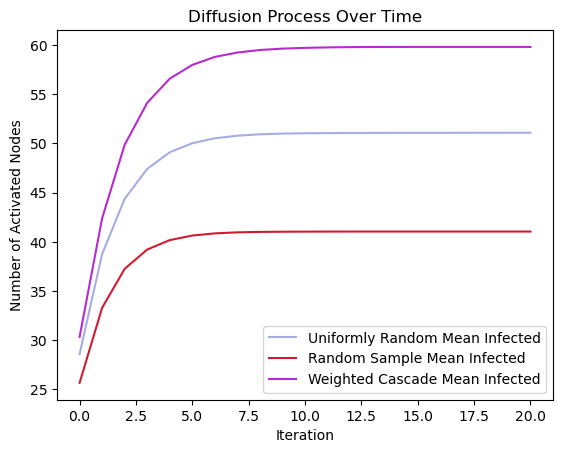

In [9]:
# Make a copy of graph and set activation probability uniformly at random in a range.
uniform_prob_graph = diff_graph.copy()
set_activation_uniformly_random(uniform_prob_graph, range_start=0.15, range_end=0.3)

# Set activation probability based on random sample.
random_prob_graph = diff_graph.copy()
set_activation_random_sample(random_prob_graph, {0.15, 0.2, 0.25})

# Set activation probability to 1/in_degree
weighted_cascade_graph = diff_graph.to_directed()
set_activation_weighted_cascade(weighted_cascade_graph)

# Use the same high-degree seed sets as chosen in the previous cell.
db.plot_num_nodes_activated(
    [
        ("Uniformly Random", uniform_prob_graph, high_deg_seeds),
        ("Random Sample", random_prob_graph, high_deg_seeds),
        ("Weighted Cascade", weighted_cascade_graph, high_deg_seeds),
    ]
)

# Influence Maximization

As a concluding example, consider the problem of [influence maximization](https://snap-stanford.github.io/cs224w-notes/network-methods/influence-maximization). Given a graph $G = (V,E)$ and a fixed budget $k$, we wish to choose a seed set $S \subseteq V$ such that $|S| = k$ and the influence $\sigma(S)$ on the graph is maximized. A common algorithm for this problem is the [CELF](https://hautahi.com/im_greedycelf) algorithm, based on the greedy algorithm.

For the purposes of this demo, we have implemented the CELF algorithm using different libraries for the backend.


Starting CELF algorithm with cynetdiff backend.
Computing initial marginal gains.


  0%|          | 0/5000 [00:00<?, ?it/s]

Performing greedy selection.


  0%|          | 0/9 [00:00<?, ?it/s]

func:'celf' took: 7.4639 sec


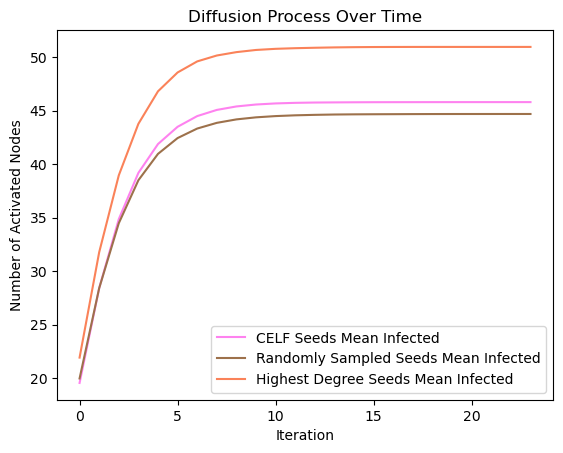

In [10]:
celf_graph = nx.watts_strogatz_graph(5_000, 10, 0.01, seed=RANDOM_SEED)
set_activation_random_sample(celf_graph, {0.1})

num_seeds = 10
# Get best seed set returned by the algorithm
# NOTE Can change the backend to see performance of different implementations.
celf_seeds, marg_gains = db.celf(celf_graph, 10, "cynetdiff")

# Now that we have our seeds, let's compare the activation behavior to other seed sets
random_seeds = set(random.sample(list(celf_graph.nodes()), num_seeds))
high_deg_seeds = sorted(celf_graph.nodes(), key=celf_graph.degree, reverse=True)[
    :num_seeds
]

# Plot the performance of CELF against other methods of choosing the seed set.
db.plot_num_nodes_activated(
    [
        ("CELF Seeds", celf_graph, celf_seeds),
        ("Randomly Sampled Seeds", celf_graph, random_seeds),
        ("Highest Degree Seeds", celf_graph, high_deg_seeds),
    ]
)